In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('AF3scoreAdded_EBV_GFP_results.csv', index_col=0)

df

,index,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5,af3_tcr_pmhc_pae_score,af3_ranking_scores,r1,r2,r3,is_binder_by_netmhcpan,is_binder_by_netmhcpan__weak
Unnamed: 0,,,,,,,,,,,,,,,
ebv_p1_wt,0.0,HPVGEADYFEY,hpvg_wt,NaN,hpvg,4.901100,0.0,1.0,1.151491,0.93,50.724005,51.117781,47.999244,1.0,1.0
ebv_p2,1.0,HPVGQADYFEY,hpvg_q5_wt,NaN,hpvg_q5,4.817275,1.0,0.0,1.133119,0.93,35.553617,33.114863,30.760143,1.0,1.0
ebv_p3,2.0,HPVGNADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.868461,3.0,3.0,1.463231,0.91,2.542713,3.913211,3.602311,1.0,1.0
ebv_p4,3.0,MPIGHADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.788419,5.0,5.0,1.160596,0.92,0.005884,0.011130,0.000000,1.0,1.0
ebv_p5,4.0,MPVGRADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.905924,4.0,4.0,1.561238,0.90,0.023636,0.000000,0.012726,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ebv_p92,10.0,FPFAYHDFTEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.926297,7.0,7.0,1.460791,0.91,0.019228,0.012566,0.007599,1.0,1.0
ebv_p93,13.0,HALGQGDEWTY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.870895,7.0,6.0,1.234344,0.92,0.023955,0.007739,0.034447,1.0,1.0
ebv_p94,28.0,FPMAFADYSEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.896537,5.0,5.0,1.093506,0.95,48.809874,51.597206,53.823573,1.0,1.0


In [2]:
# add epsilon to avoid division by zero, there is one datapoint being nasty
eps = 1e-3
df['r1'] = df['r1'] + eps
df['r2'] = df['r2'] + eps
df['r3'] = df['r3'] + eps

cutoff = max(0.5, df.loc['unstim', ['r1', 'r2', 'r3']].mean() + df.loc['unstim', ['r1', 'r2', 'r3']].std() * 3)

print(cutoff)

# df['r1_resp'] = df['r1'] > cutoff
# df['r2_resp'] = df['r2'] > cutoff
# df['r3_resp'] = df['r3'] > cutoff

# # resp is if all resp positively
# df['Resp'] = df[['r1_resp', 'r2_resp', 'r3_resp']].all(axis=1)

df['resp'] = [True if elem > cutoff else False for elem in df[['r1', 'r2', 'r3']].mean(axis=1)]

df['r_mean'] = [np.mean([r1, r2, r3]) for r1, r2, r3 in zip(df['r1'], df['r2'], df['r3'])]

resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}
model_to_marker = {'hpvg_wt': 'X', 'hpvg_q5_wt': 'X', 'so3_convnet_base_ensemble__fixed_structure': 's', 'so3_convnet_noise=0p5__fixed_structure': 'd', 'so3_convnet_base_ensemble__sim_anneal': '<', 'so3_convnet_noise=0p5__sim_anneal': '>'}
models = list(model_to_marker.keys())

def get_model_mask(df, model_and_method):
    model_and_method_split = model_and_method.split('__')[0]
    if len(model_and_method.split('__')) == 1:
        return df['model'] == model_and_method
    elif len(model_and_method.split('__')) == 2:
        return (df['model'] == model_and_method.split('__')[0]) & (df['sampling_method'] == model_and_method.split('__')[1])
    else:
        raise ValueError('model_and_method must have at most one "__"')

df['min_hamming_distance_from_struc'] = np.min(df[['hamming_distances_from_hpvg', 'hamming_distance_from_hpvg_q5']], axis=1)


score_wt = df.loc[df['model'] == 'hpvg_wt', ['r1', 'r2', 'r3']].values[0]
score_wt_q5 = df.loc[df['model'] == 'hpvg_q5_wt', ['r1', 'r2', 'r3']].values[0]

pae_wt = df.loc[df['model'] == 'hpvg_wt', 'tcrdock_pae'].values[0]
pae_wt_q5 = df.loc[df['model'] == 'hpvg_q5_wt', 'tcrdock_pae'].values[0]

af3_pae_wt = df.loc[df['model'] == 'hpvg_wt', 'af3_tcr_pmhc_pae_score'].values[0]
af3_pae_wt_q5 = df.loc[df['model'] == 'hpvg_q5_wt', 'af3_tcr_pmhc_pae_score'].values[0]

print(pae_wt, pae_wt_q5)

# remove wildtypes, corresponding to indices values ebv_p1_wt and ebv_p2
df = df.drop(['ebv_p1_wt', 'ebv_p2'])


# remove unstim
unstim_values = df.loc['unstim'][['r1', 'r2', 'r3']].values
print(unstim_values)

unstim_values = np.array([0.311142367, 0.004291111, 0.001])

df = df.drop('unstim')

df

0.6398327818047831
4.901100366 4.817274817
[0.311142367 0.004291111 0.001]


,index,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5,af3_tcr_pmhc_pae_score,af3_ranking_scores,r1,r2,r3,is_binder_by_netmhcpan,is_binder_by_netmhcpan__weak,resp,r_mean,min_hamming_distance_from_struc
Unnamed: 0,,,,,,,,,,,,,,,,,,
ebv_p3,2.0,HPVGNADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.868461,3.0,3.0,1.463231,0.91,2.543713,3.914211,3.603311,1.0,1.0,True,3.353745,3.0
ebv_p4,3.0,MPIGHADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.788419,5.0,5.0,1.160596,0.92,0.006884,0.012130,0.001000,1.0,1.0,False,0.006671,5.0
ebv_p5,4.0,MPVGRADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.905924,4.0,4.0,1.561238,0.90,0.024636,0.001000,0.013726,1.0,1.0,False,0.013121,4.0
ebv_p6,5.0,HPMGMADHWMY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.941916,5.0,5.0,1.182298,0.93,0.023938,0.042408,0.025454,1.0,1.0,False,0.030600,5.0
ebv_p7,6.0,HPVGRADFWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.992226,4.0,4.0,1.409040,0.90,0.003812,0.060240,0.013626,1.0,1.0,False,0.025893,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ebv_p91,36.0,MPLGQADFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg_q5,4.784465,6.0,5.0,1.179768,0.92,0.355124,0.290279,0.234749,1.0,1.0,False,0.293384,5.0
ebv_p92,10.0,FPFAYHDFTEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.926297,7.0,7.0,1.460791,0.91,0.020228,0.013566,0.008599,1.0,1.0,False,0.014131,7.0
ebv_p93,13.0,HALGQGDEWTY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.870895,7.0,6.0,1.234344,0.92,0.024955,0.008739,0.035447,1.0,1.0,False,0.023047,6.0


In [6]:
pairs = list(zip(df['sampling_method'].values, df['wt_for_design'].values))
from collections import Counter
print(Counter(pairs))

Counter({('fixed_structure', 'hpvg'): 24, ('sim_anneal', 'hpvg'): 23, ('fixed_structure', 'hpvg_q5'): 23, ('sim_anneal', 'hpvg_q5'): 23})


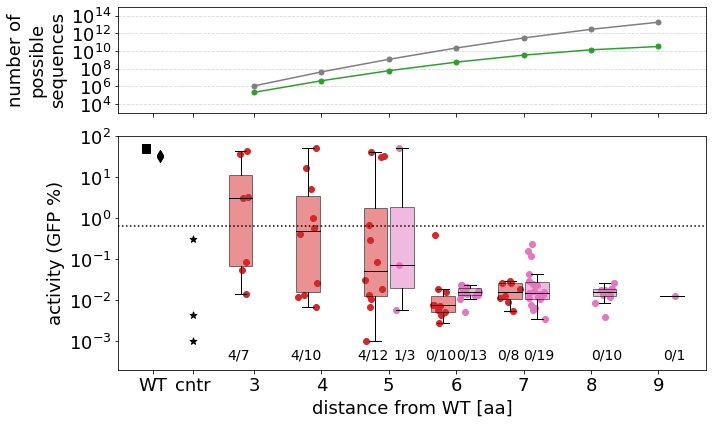

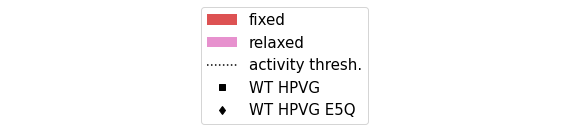

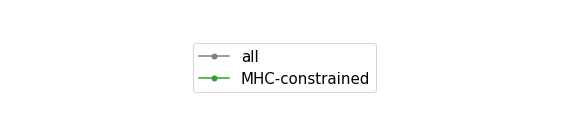

In [7]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import gridspec

fontsize = 18

# make a barplot of success over distance from wildtype for the 4 model classes
model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure'), ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal')]
model_group_names = ['fixed', 'annealing']
colors = ['tab:red', 'tab:pink']

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2.2])

# Bottom subplot
ax = fig.add_subplot(gs[1])

df_here = df.loc[df['tcrdock_pae'] < 5.5]

all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))

for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
    mask1 = get_model_mask(df, model_group[0])
    mask2 = get_model_mask(df, model_group[1])
    mask = np.logical_or(mask1, mask2)
    curr_df = df_here[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['resp'].values

    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
        
    distance_to_exp_score = {}
    distance_to_min_exp_score = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_exp_score[distance] = np.vstack([curr_df[dist_mask]['r1'],
                                                                  curr_df[dist_mask]['r2'],
                                                                  curr_df[dist_mask]['r3']])
        distance_to_min_exp_score[distance] = np.mean(distance_to_exp_score[distance], axis=0)
    
    distances = list(distance_to_exp_score.keys())
    scores = [np.log10(distance_to_exp_score[distance]) for distance in distances]
    min_scores = [np.log10(distance_to_min_exp_score[distance]) for distance in distances]

    positions = [distance - 0.2 + i*0.4 for distance in distances]

    ax.boxplot(min_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

    k = 0
    for position, scores_in_distance in zip(positions, min_scores):
        if len(scores_in_distance.shape) == 2:
            scores_in_distance = scores_in_distance.T
        for item in scores_in_distance:
            noise = np.random.uniform(-0.15, 0.15)
            len_item = len(item) if isinstance(item, np.ndarray) else 1
            if k == 0:
                ax.scatter([position+noise]*len_item, item, color=color, label=model_group_name)
                # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
            else:
                ax.scatter([position+noise]*len_item, item, color=color)
                # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
            k += 1

    # put number of examples under each boxplot
    ax.set_ylim(-3.7, 2)
    for position, distance, scores_in_distance in zip(positions, distances, min_scores):
        offset = 0.03 if i == 1 else -0.03
        ax.text(position+offset, -3.5, f'{int(distance_to_resp[distance][True])}/{len(scores_in_distance)}', ha='center', va='bottom', fontsize=fontsize-4)


min_distance = min(all_distances)
wt_xtick = min_distance - 1.5
control_xtick = wt_xtick + 0.6

ax.scatter([wt_xtick-0.1]*len(score_wt), np.log10(score_wt), color='black', marker='s', s=50)
ax.scatter([wt_xtick+0.1]*len(score_wt_q5), np.log10(score_wt_q5), color='black', marker='d', s=50)
ax.scatter([control_xtick]*len(unstim_values), np.log10(unstim_values), color='black', marker='*', s=50)

ax.axhline(np.log10(cutoff), color='black', linestyle=':', label='activity thresh.')

xticks = [wt_xtick, control_xtick] + list(all_distances)
xticklabels = ['WT', 'cntr'] + [str(int(distance)) for distance in all_distances]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

yticks = [-3, -2, -1, 0, 1, 2]
ax.set_yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks])

ax.tick_params(axis='both', labelsize=fontsize)


ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
ax.set_ylabel('activity (GFP %)', fontsize=fontsize)


import json
with open('mhc_constrainted_class_I_B3501_11_ebv_k_to_num_sequences.json', 'r') as f:
    k_to_num_sequences_mhc = json.load(f)
with open('all_possibilities_class_I_B3501_11_ebv_k_to_num_sequences.json', 'r') as f:
    k_to_num_sequences_all = json.load(f)

all_values = [k_to_num_sequences_all[str(int(k))] for k in all_distances]
mhc_values = [k_to_num_sequences_mhc[str(int(k))] for k in all_distances]

# put mhc_values on the plot, show ticks and label on right y-axis, in log-scale
# Top subplot
ax2 = fig.add_subplot(gs[0], sharex=ax)
ax2.plot(all_distances, np.log10(all_values), color='tab:grey', linestyle='-', marker='o', markersize=5, label='all')
ax2.plot(all_distances, np.log10(mhc_values), color='tab:green', linestyle='-', marker='o', markersize=5, label='MHC-constrained')
# ax2.set_yticks(np.log10(mhc_values))
# ax2.set_yticklabels(mhc_values)
# ax2.set_ylim(ax.get_ylim())

ax2.tick_params(labelbottom=False)

ax2.set_ylim([3, 15])
yticks = [4, 6, 8, 10, 12, 14]
ax2.set_yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks])

ax2.tick_params(axis='y', labelsize=fontsize)
ax2.set_ylabel('number of\npossible\nsequences', fontsize=fontsize)

ax2.grid(axis='y', linestyle='--', alpha=0.5)


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(facecolor='tab:red', alpha=0.8, label='fixed'),
                    Patch(facecolor='tab:pink', alpha=0.8, label='relaxed'),
                    Line2D([0], [0], color='black', linestyle=':', label='activity thresh.'),
                    Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT HPVG'),
                    Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT HPVG E5Q')]

legend_handles_2 = ax2.get_legend_handles_labels()[0]

# # put legend outside of figure on the right
# ax.legend(handles=legend_handles, fontsize=fontsize-3, bbox_to_anchor=(1.32, 0.80))
# ax2.legend(fontsize=fontsize-3, bbox_to_anchor=(1.32, 0.80))

plt.tight_layout()
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt.png')
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt.pdf')
plt.show()

# put legends in separate figures
fig_leg_1 = plt.figure(figsize=(8, 2))
ax_leg_1 = fig_leg_1.add_subplot(111)
ax_leg_1.legend(handles=legend_handles, fontsize=fontsize-3, loc='center')
ax_leg_1.axis('off')
plt.tight_layout()
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt_legend_bottom.png')
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt_legend_bottom.pdf')
plt.show()

fig_leg_2 = plt.figure(figsize=(8, 2))
ax_leg_2 = fig_leg_2.add_subplot(111)
ax_leg_2.legend(handles=legend_handles_2, fontsize=fontsize-3, loc='center')
ax_leg_2.axis('off')
plt.tight_layout()
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt_legend_top.png')
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt_legend_top.pdf')
plt.show()

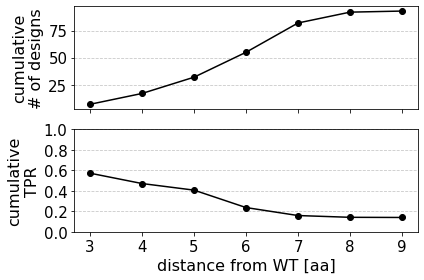

In [5]:
df_here = df.loc[df['tcrdock_pae'] < 5.5]

all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))


distances = df_here['min_hamming_distance_from_struc'].values
responses = df_here['resp'].values

distance_to_resp = {}
for distance in np.unique(distances):
    dist_mask = distances == distance
    distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}

cumulative_distance_to_resp = {}
for distance in all_distances:
    cumulative_distance_to_resp[distance] = {True: sum([distance_to_resp[dist][True] for dist in all_distances if dist <= distance]),
                                            False: sum([distance_to_resp[dist][False] for dist in all_distances if dist <= distance])}

# make plot of true positive rate below and including a certain distance threshold
# blow it, in a different subplot, make plot of total number of peptides
fontsize = 16

colsize = 6
rowsize = 2
ncols = 1
nrows = 2
fig, axs = plt.subplots(figsize=(colsize*ncols, rowsize*nrows), ncols=ncols, nrows=nrows, sharex=True)

ax = axs[0]
ax.plot(all_distances, [cumulative_distance_to_resp[distance][True] + cumulative_distance_to_resp[distance][False] for distance in all_distances], color='black', marker='o')
ax.set_ylabel('cumulative\n# of designs', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize-1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax = axs[1]
ax.plot(all_distances, [cumulative_distance_to_resp[distance][True] / (cumulative_distance_to_resp[distance][True] + cumulative_distance_to_resp[distance][False]) for distance in all_distances], color='black', marker='o')
ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
ax.set_ylabel('cumulative\nTPR', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize-1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('__pretty_cumulative_tpr_and_num_designs_vs_hamming_distance_from_wt.png')
plt.savefig('__pretty_cumulative_tpr_and_num_designs_vs_hamming_distance_from_wt.pdf')
plt.show()

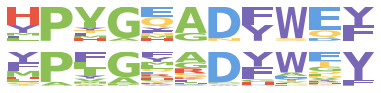

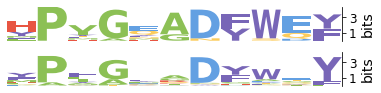

In [4]:
# 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# write the number of sequences in each logoplot

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
import logomaker

import sys
sys.path.append('../../../src/')
from global_constants import LOGOMAKER_COLORS

def entropy(p):
    return -np.nansum(p * np.log2(p + 1e-10))

def get_pwm(df_, use_entropy=False):
    seqs = df_['sequence']
    pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
    for seq in seqs:
        assert len(seq) == len_seq
        for i, aa in enumerate(seq):
            pwm[i, AMINO_ACIDS.index(aa)] += 1
    pwm = pwm / pwm.sum(axis=1)[:, None]
    pwm[np.isnan(pwm)] = 0

    if use_entropy:
        ics = []
        for row in pwm:
            ics.append(np.log2(20) - entropy(row))
        ics = np.array(ics)
        pwm = pwm * ics[:, np.newaxis]

    return pwm

fontsize = 16

len_seq = len(df['sequence'].values[0])




def make_logoplot_tp_fp(use_entropy=False):

    nrows = 2
    ncols = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5.4, nrows*0.7))

    df_true_below = df[(df['resp'] == True)]
    df_false_below = df[(df['resp'] == False)]

    # get sequences, make pwm
    pwm_true_below = get_pwm(df_true_below, use_entropy=use_entropy)
    df_pwm_true_below = pd.DataFrame(pwm_true_below, columns=AMINO_ACIDS)
    pwm_false_below = get_pwm(df_false_below, use_entropy=use_entropy)
    df_pwm_false_below = pd.DataFrame(pwm_false_below, columns=AMINO_ACIDS)

    for row, (title, df_, num_seqs) in enumerate(zip(['true positives', 'false positives'],
                                                        [df_pwm_true_below, df_pwm_false_below],
                                                        [len(df_true_below), len(df_false_below)])):

        ax = axs[row]

        logomaker.Logo(df_, ax=ax, color_scheme=LOGOMAKER_COLORS)

        # ax.set_title(title + f'\n{num_seqs} peptides', fontsize=fontsize)

        ax.set_xticks(np.arange(len_seq), np.arange(len_seq)+1)

        if use_entropy:
            ax.set_ylim([0, np.log2(20)])
        else:
            ax.set_ylim([0, 1])

        # # Remove y-ticks
        # ax.tick_params(axis='y', which='both', length=0)

        # Remove x-tick marks but keep the labels
        ax.tick_params(axis='x', which='both', length=0)

        ax.tick_params(axis='x', labelsize=fontsize)

        ax.set_xticks([])

        # Remove all the spines
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        if not use_entropy:
            ax.spines['right'].set_visible(False)
            ax.set_yticks([])
        else:
            ax.yaxis.set_ticks_position('right')  # Set ticks on the right
            ax.yaxis.set_label_position('right')  # Set the label on the right
            ax.set_ylabel('bits', fontsize=fontsize-2)
            ax.set_yticks([1, 3])
            ax.tick_params(axis='y', labelsize=fontsize-4)
    
    if use_entropy:
        use_entropy_str = '_norm_entropy'
    else:
        use_entropy_str = ''

    plt.tight_layout()
    plt.savefig(f'__pretty_ebv_logoplot{use_entropy_str}.pdf')
    plt.savefig(f'__pretty_ebv_logoplot{use_entropy_str}.png')
    plt.show()

make_logoplot_tp_fp(use_entropy=False)
make_logoplot_tp_fp(use_entropy=True)



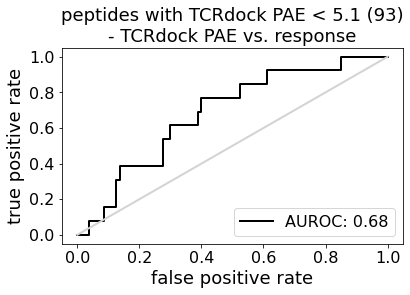

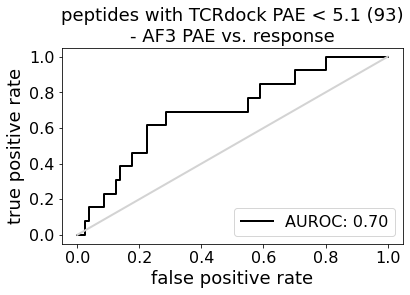

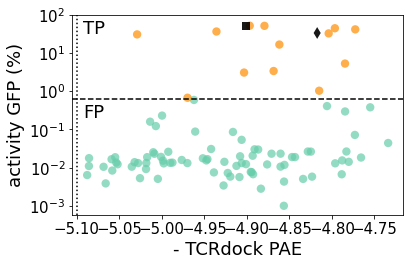

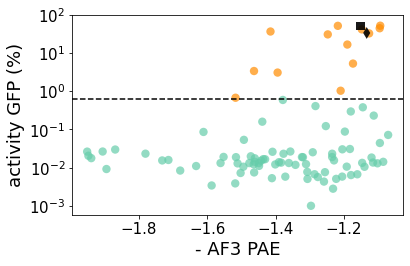

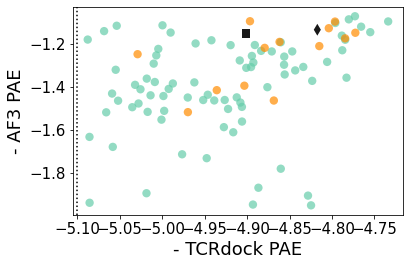

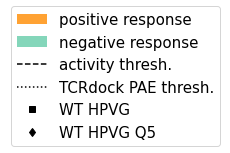

In [8]:
fontsize = 18

# roc curve plot and auroc for tcrdock_pae
fpr, tpr, _ = roc_curve(df['resp'], -df['tcrdock_pae'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.8, 4.2))
plt.title(f'peptides with TCRdock PAE < 5.1 ({len(df)})\n- TCRdock PAE vs. response', fontsize=fontsize)
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('false positive rate', fontsize=fontsize)
plt.ylabel('true positive rate', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)
# plt.title('TCRdock TCR-pMHC PAE', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize-2)
plt.tight_layout()
plt.savefig(f'__pretty_ebv_roc_positive_peptides.png')
plt.savefig(f'__pretty_ebv_roc_positive_peptides.pdf')
plt.show()


fpr, tpr, _ = roc_curve(df['resp'], -df['af3_tcr_pmhc_pae_score'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.8, 4.2))
plt.title(f'peptides with TCRdock PAE < 5.1 ({len(df)})\n- AF3 PAE vs. response', fontsize=fontsize)
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('false positive rate', fontsize=fontsize)
plt.ylabel('true positive rate', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)
# plt.title('TCRdock TCR-pMHC PAE', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize-2)
plt.tight_layout()
plt.savefig(f'__pretty_ebv_roc_positive_peptides_af3.png')
plt.savefig(f'__pretty_ebv_roc_positive_peptides_af3.pdf')
plt.show()


colors = {True: 'darkorange', False: 'mediumaquamarine'}

predictor = 'tcrdock_pae'
measurement = 'r_mean'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(-df[df['resp'] == response][predictor], np.log10(df[df['resp'] == response][measurement]), c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(-pae_wt, np.log10(np.mean(score_wt)), marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(-pae_wt_q5, np.log10(np.mean(score_wt_q5)), marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

plt.axvline(-5.1, color='black', linestyle=':')
plt.axhline(np.log10(cutoff), color='black', linestyle='--')

plt.xlabel('- TCRdock PAE', fontsize=fontsize)
plt.ylabel('activity GFP (%)', fontsize=fontsize)
yticks = [-3, -2, -1, 0, 1, 2]
plt.yticks(yticks, ['$10^{}$'.format('{' + str(y) + '}') for y in yticks], fontsize=fontsize-3)
plt.xticks(fontsize=fontsize-3)

# plt.ylim([-0.6, np.log10(24)])

plt.text(-5.092, 1.5, 'TP', fontsize=fontsize)
plt.text(-5.092, -0.7, 'FP', fontsize=fontsize)
# plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
# plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_ebv_scatterplot.png')
plt.savefig(f'__pretty_ebv_scatterplot.pdf')
plt.show()



predictor = 'af3_tcr_pmhc_pae_score'
measurement = 'r_mean'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(-df[df['resp'] == response][predictor], np.log10(df[df['resp'] == response][measurement]), c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(-af3_pae_wt, np.log10(np.mean(score_wt)), marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(-af3_pae_wt_q5, np.log10(np.mean(score_wt_q5)), marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

# plt.axvline(5.5, color='black', linestyle=':')
plt.axhline(np.log10(cutoff), color='black', linestyle='--')

plt.xlabel('- AF3 PAE', fontsize=fontsize)
plt.ylabel('activity GFP (%)', fontsize=fontsize)

yticks = [-3, -2, -1, 0, 1, 2]
plt.yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks], fontsize=fontsize-3)
plt.xticks(fontsize=fontsize-3)

# plt.text(5.4, np.log10(35), 'TP', fontsize=fontsize)
# plt.text(5.4, np.log10(0.17), 'FP', fontsize=fontsize)
# plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
# plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_ebv_scatterplot_af3.png')
plt.savefig(f'__pretty_ebv_scatterplot_af3.pdf')
plt.show()


predictor = 'tcrdock_pae'
measurement = 'af3_tcr_pmhc_pae_score'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(-df[df['resp'] == response][predictor], -df[df['resp'] == response][measurement], c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(-pae_wt, -af3_pae_wt, marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(-pae_wt_q5, -af3_pae_wt_q5, marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

plt.axvline(-5.1, color='black', linestyle=':')
# plt.axhline(np.log10(score_threshold), color='black', linestyle=':')

plt.ylabel('- AF3 PAE', fontsize=fontsize)
plt.xlabel('- TCRdock PAE', fontsize=fontsize)

# yticks = [-3, -2, -1, 0, 1, 2]
# plt.yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks], fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-3)
plt.xticks(fontsize=fontsize-3)

# plt.text(5.4, np.log10(35), 'TP', fontsize=fontsize)
# plt.text(5.4, np.log10(0.17), 'FP', fontsize=fontsize)
# plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
# plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_ebv_scatterplot_tcrdock_vs_af3.png')
plt.savefig(f'__pretty_ebv_scatterplot_tcrdock_vs_af3.pdf')
plt.show()


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(facecolor=colors[True], alpha=0.8, label='positive response'),
                    Patch(facecolor=colors[False], alpha=0.8, label='negative response'),
                    Line2D([0], [0], color='black', linestyle='--', label='activity thresh.'),
                    Line2D([0], [0], color='black', linestyle=':', label='TCRdock PAE thresh.'),
                    Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT HPVG'),
                    Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT HPVG Q5')]


# put legends in separate figures
fig_leg_1 = plt.figure(figsize=(3.5, 2))
ax_leg_1 = fig_leg_1.add_subplot(111)
ax_leg_1.legend(handles=legend_handles, fontsize=fontsize-3, loc='center')
ax_leg_1.axis('off')
plt.tight_layout()
plt.savefig('__pretty_scatterplots_legend.png')
plt.savefig('__pretty_scatterplots_legend.pdf')
plt.show()


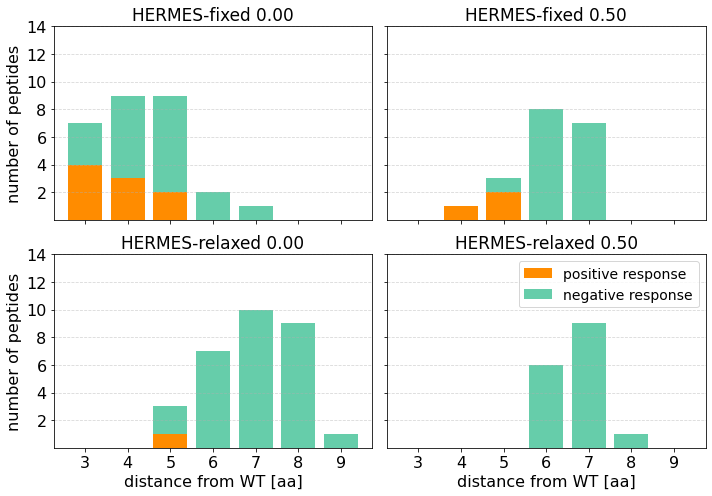

In [6]:
# make a barplot of success over distance from wildtype for the 4 model classes
models_of_interest = ['so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal']

model_name_to_pretty_name = {
    'so3_convnet_base_ensemble__fixed_structure': 'HERMES-fixed 0.00',
    'so3_convnet_noise=0p5__fixed_structure': 'HERMES-fixed 0.50',
    'so3_convnet_base_ensemble__sim_anneal': 'HERMES-relaxed 0.00',
    'so3_convnet_noise=0p5__sim_anneal': 'HERMES-relaxed 0.50'
}

model_plus_method = []
for i, row in df.iterrows():
    if 'base_ensemble' in row['model'] and row['sampling_method'] == 'fixed_structure':
        model_plus_method.append('so3_convnet_base_ensemble__fixed_structure')
    elif 'base_ensemble' in row['model'] and row['sampling_method'] == 'sim_anneal':
        model_plus_method.append('so3_convnet_base_ensemble__sim_anneal')
    elif 'noise' in row['model'] and row['sampling_method'] == 'fixed_structure':
        model_plus_method.append('so3_convnet_noise=0p5__fixed_structure')
    elif 'noise' in row['model'] and row['sampling_method'] == 'sim_anneal':
        model_plus_method.append('so3_convnet_noise=0p5__sim_anneal')
df['model_plus_method'] = model_plus_method

resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}

fontsize = 16

ncols = 2
nrows = 2
colsize = 5
rowsize = 3.5
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

for i, (ax, model) in enumerate(zip(axs.flatten(), models_of_interest)):
    mask = df['model_plus_method'] == model
    curr_df = df[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['resp'].values

    # barplot with distance on x axis, and on y axis positive resp in one color, negative resp in another color
    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
    
    distances = list(distance_to_resp.keys())
    pos_responses = [distance_to_resp[distance][True] for distance in distances]
    neg_responses = [distance_to_resp[distance][False] for distance in distances]

    row = i // ncols
    col = i % ncols

    ax.bar(distances, pos_responses, color=resp_to_color[True])
    ax.bar(distances, neg_responses, bottom=pos_responses, color=resp_to_color[False])
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    ax.set_title(model_name_to_pretty_name[model], fontsize=fontsize+1)
    ax.set_xticks([3, 4, 5, 6, 7, 8, 9])
    ax.set_yticks([2, 4, 6, 8, 10, 12, 14])
    ax.tick_params(axis='both', labelsize=fontsize)
    if row == nrows-1: ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
    if col == 0: ax.set_ylabel('number of peptides', fontsize=fontsize)

    if row == nrows-1 and col == ncols-1:
        ax.legend(['positive response', 'negative response'], fontsize=fontsize-2)

plt.tight_layout()
plt.savefig('__pretty_hits_vs_hamming_distance_from_wt_split_by_model.png')
plt.savefig('__pretty_hits_vs_hamming_distance_from_wt_split_by_model.pdf')
plt.show()

In [7]:
df

,index,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5,af3_tcr_pmhc_pae_score,af3_ranking_scores,r1,r2,r3,is_binder_by_netmhcpan,is_binder_by_netmhcpan__weak,resp,r_mean,min_hamming_distance_from_struc,model_plus_method
Unnamed: 0,,,,,,,,,,,,,,,,,,,
ebv_p3,2.0,HPVGNADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.868461,3.0,3.0,1.463231,0.91,2.543713,3.914211,3.603311,1.0,1.0,True,3.353745,3.0,so3_convnet_base_ensemble__fixed_structure
ebv_p4,3.0,MPIGHADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.788419,5.0,5.0,1.160596,0.92,0.006884,0.012130,0.001000,1.0,1.0,False,0.006671,5.0,so3_convnet_base_ensemble__fixed_structure
ebv_p5,4.0,MPVGRADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.905924,4.0,4.0,1.561238,0.90,0.024636,0.001000,0.013726,1.0,1.0,False,0.013121,4.0,so3_convnet_base_ensemble__fixed_structure
ebv_p6,5.0,HPMGMADHWMY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.941916,5.0,5.0,1.182298,0.93,0.023938,0.042408,0.025454,1.0,1.0,False,0.030600,5.0,so3_convnet_base_ensemble__fixed_structure
ebv_p7,6.0,HPVGRADFWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.992226,4.0,4.0,1.409040,0.90,0.003812,0.060240,0.013626,1.0,1.0,False,0.025893,4.0,so3_convnet_base_ensemble__fixed_structure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ebv_p91,36.0,MPLGQADFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg_q5,4.784465,6.0,5.0,1.179768,0.92,0.355124,0.290279,0.234749,1.0,1.0,False,0.293384,5.0,so3_convnet_base_ensemble__fixed_structure
ebv_p92,10.0,FPFAYHDFTEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.926297,7.0,7.0,1.460791,0.91,0.020228,0.013566,0.008599,1.0,1.0,False,0.014131,7.0,so3_convnet_base_ensemble__sim_anneal
ebv_p93,13.0,HALGQGDEWTY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.870895,7.0,6.0,1.234344,0.92,0.024955,0.008739,0.035447,1.0,1.0,False,0.023047,6.0,so3_convnet_base_ensemble__sim_anneal


In [8]:
top_peptides = df.loc[np.logical_and(df['min_hamming_distance_from_struc'] >= 4, df['resp'] == True)]['sequence'].values

mhc = 'GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENG'
tcra = 'EDQVTQSPEALRLQEGESSSLNCSYTVSGLRGLFWYRQDPGKGPEFLFTLYSAGEEKEKERLKATLTKKESFLHITAPKPEDSATYLCAVQDLGTSGSRLTFGEGTQLTVNP'
tcrb = 'DSGVTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQYYNGEERAKGNILERFSAQQFPDLHSELNLSSLELGDSALYFCASSARSGELFFGEGSRLTVL'


def make_json(mhc, tcra, tcrb, peptides, name=''):

    import json

    json_data = []
    for peptide in peptides:
        curr_json = {}
        curr_json['name'] = f'{name}_{peptide}'
        curr_json['modelSeeds'] = []
        curr_json['sequences'] = [
            {'proteinChain': {
                'sequence': mhc,
                'count': 1
            }},
            {'proteinChain': {
                'sequence': peptide,
                'count': 1
            }},
            {'proteinChain': {
                'sequence': tcra,
                'count': 1
            }},
            {'proteinChain': {
                'sequence': tcrb,
                'count': 1
            }},
        ]
        json_data.append(curr_json)
    
    with open(f'{name}.json', 'w') as f:
        json.dump(json_data, f, indent=4)

make_json(mhc, tcra, tcrb, top_peptides, name='ebv')